In [1]:
#https://www.youtube.com/watch?v=5_6O2oDy5Jk
#https://github.com/rfordatascience/tidytuesday/tree/master/data/2018/2018-11-13
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
Warning message:
“package ‘purrr’ was built under R version 3.6.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
library(malariaAtlas)
library(mapproj)

In [3]:
kenya_pr <- getPR(ISO = 'KEN', species = 'BOTH') %>%
                filter(!is.na(pr))

Creating list of countries for which MAP data is available, please wait...
Confirming availability of PR data for: KEN...
PR points are available for KEN.
Attempting to download PR point data for Kenya ...
Data downloaded for KEN.


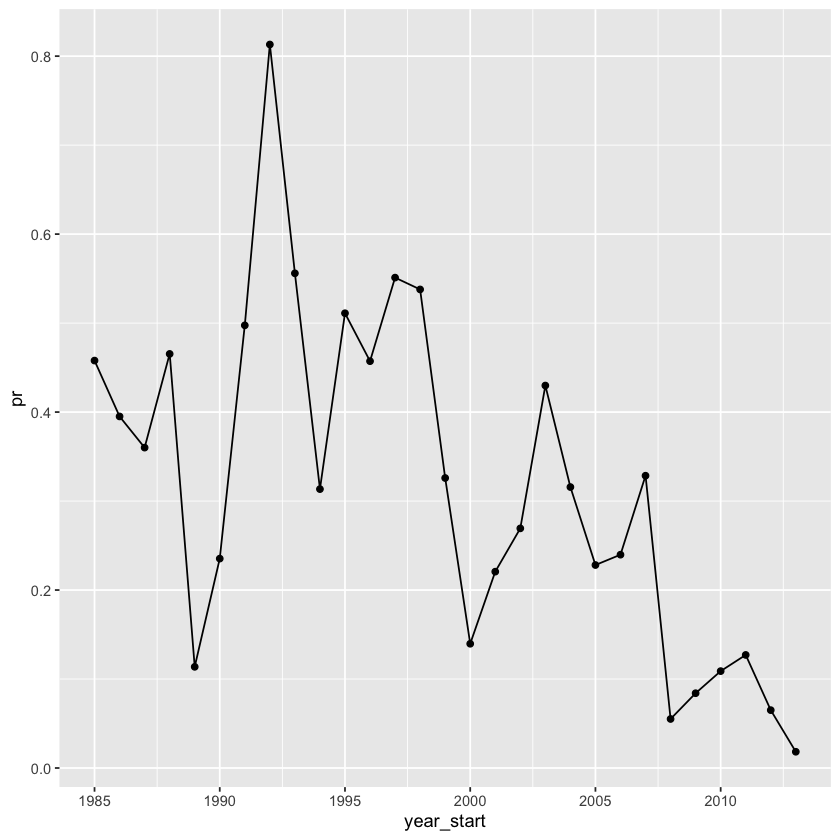

In [4]:
# total per year:
kenya_pr %>% filter(!is.na(year_start)) %>%
                group_by(year_start) %>% 
                summarise(examined = sum(examined), 
                          positive = sum(positive), 
                          pr = positive / examined, 
                          studies = n()) %>%
            ggplot(aes(year_start, pr)) +
            geom_point() + geom_line()

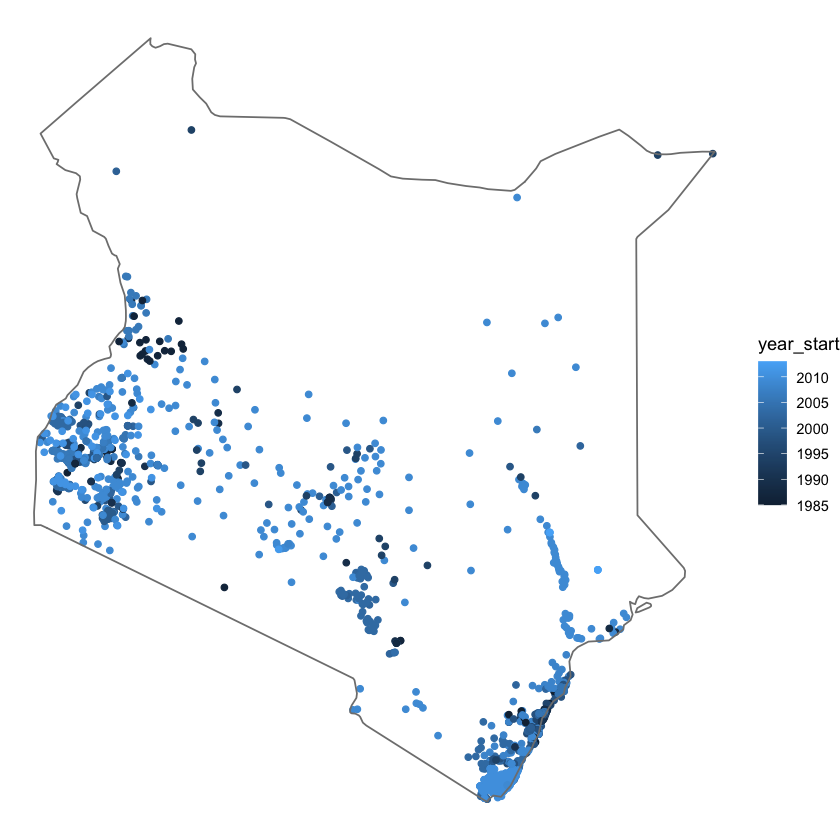

In [5]:
kenya_pr %>% ggplot(aes(longitude, latitude, color = year_start)) + 
                geom_point() + 
                borders(database = "world", regions = "kenya") +
                theme_void()

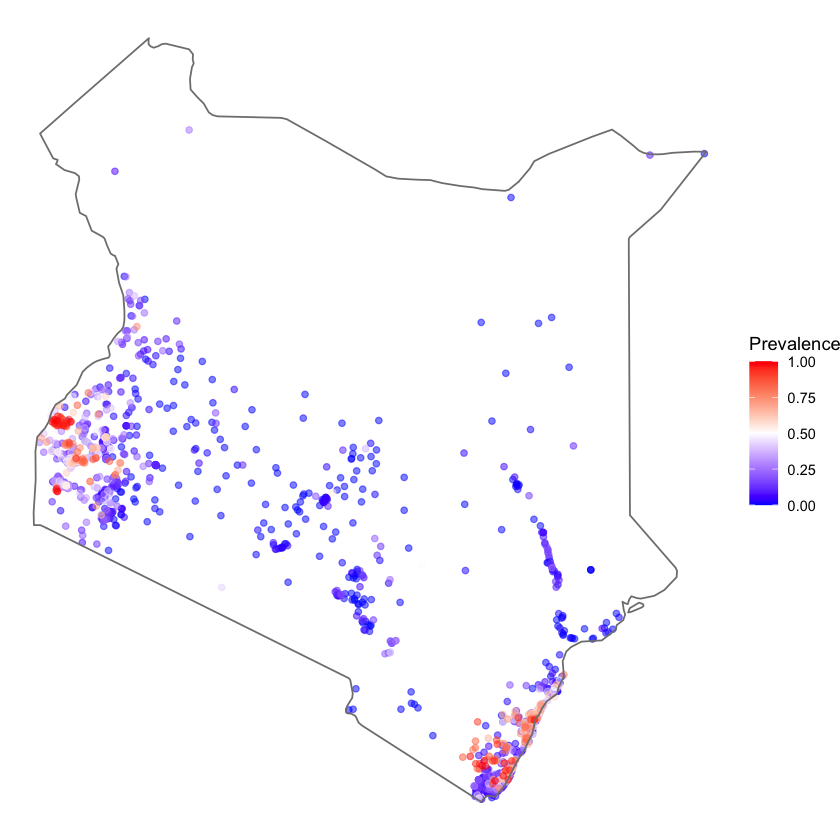

In [6]:
kenya_pr %>% arrange(pr) %>%
                ggplot(aes(longitude, latitude, color = pr)) + 
                geom_point(alpha = 0.5) + 
                scale_color_gradient2(low = 'blue', high = 'red', midpoint = .5) +
                borders(database = 'world', regions = 'kenya') +
                theme_void() +
                labs(color = 'Prevalence')

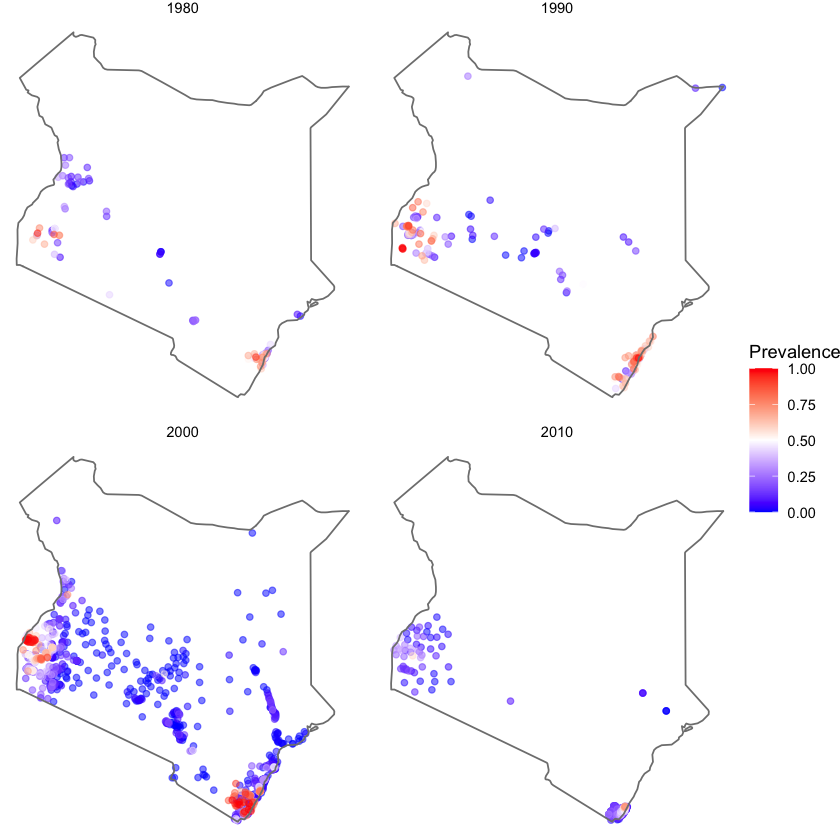

In [7]:
kenya_pr %>% arrange(pr) %>%
                mutate(decade = 10 * year_start %/% 10) %>%
                ggplot(aes(longitude, latitude, color = pr)) + 
                geom_point(alpha = 0.5) + 
                facet_wrap(~decade) +
                scale_color_gradient2(low = 'blue', high = 'red', midpoint = .5) +
                borders(database = 'world', regions = 'kenya') +
                theme_void() +
                labs(color = 'Prevalence')

## Aggregated Data:

In [8]:
malaria_inc <- read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_inc.csv")
names(malaria_inc)

Parsed with column specification:
cols(
  Entity = col_character(),
  Code = col_character(),
  Year = col_double(),
  `Incidence of malaria (per 1,000 population at risk) (per 1,000 population at risk)` = col_double()
)


[1] "Entity"                                                                            
[2] "Code"                                                                              
[3] "Year"                                                                              
[4] "Incidence of malaria (per 1,000 population at risk) (per 1,000 population at risk)"

In [9]:
malaria_inc_processed <- malaria_inc %>%                     
                                set_names(c('country', 'code', 'year', 'incidence')) %>%
                                filter(country != 'Turkey') %>%
                                mutate(incidence = incidence / 1000)


head(malaria_inc_processed)

country,code,year,incidence
<chr>,<chr>,<dbl>,<dbl>
Afghanistan,AFG,2000,1.071000e-01
Afghanistan,AFG,2005,4.650000e-02
Afghanistan,AFG,2010,2.390000e-02
Afghanistan,AFG,2015,2.360000e-02
Algeria,DZA,2000,3.774626e-05
Algeria,DZA,2005,2.021410e-06


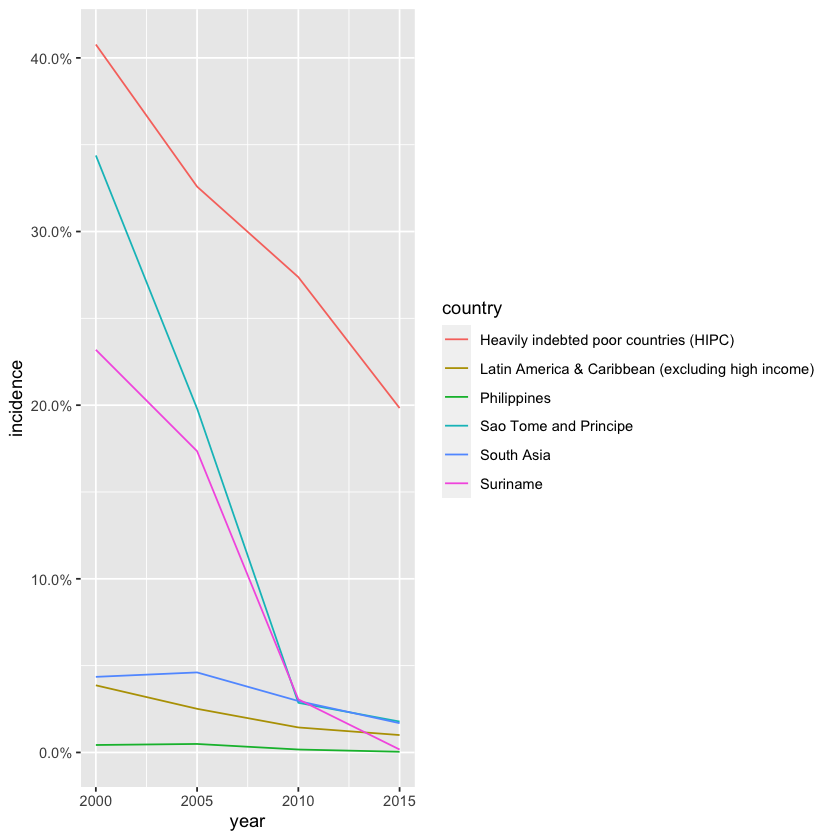

In [10]:
malaria_inc_processed %>% filter(country %in% sample(unique(country), 6)) %>%
                ggplot(aes(year, incidence, color = country)) +
                geom_line() +
                scale_y_continuous(labels = scales::percent_format())

In [11]:
malaria_spread <- malaria_inc_processed %>% 
                        mutate(year = paste0('Y', year)) %>%
                        spread(year, incidence)

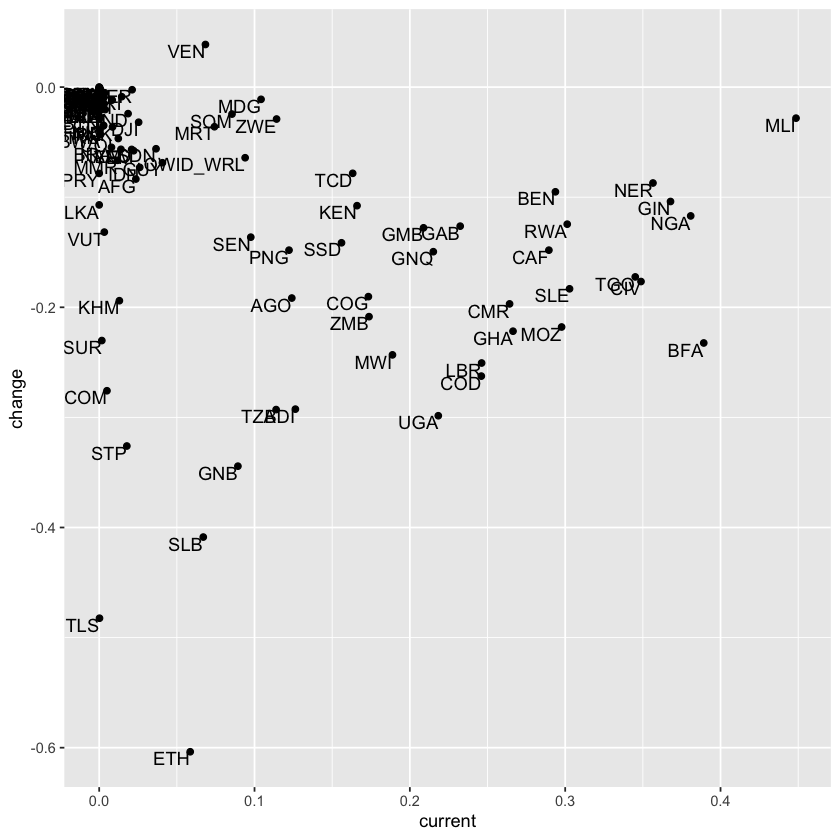

In [12]:
malaria_spread %>% 
                filter(country != 'Turkey', 
                       !is.na(code)) %>%
                mutate(current = Y2015, 
                       change = Y2015 - Y2000) %>%
                arrange(desc(change)) %>% 
                ggplot(aes(current, change)) + 
                geom_point() +
                geom_text(aes(label = code), vjust = 1, hjust = 1)

In [13]:
world <- map_data('world') %>% filter(region != 'Antarctica')
#unique(world$region)

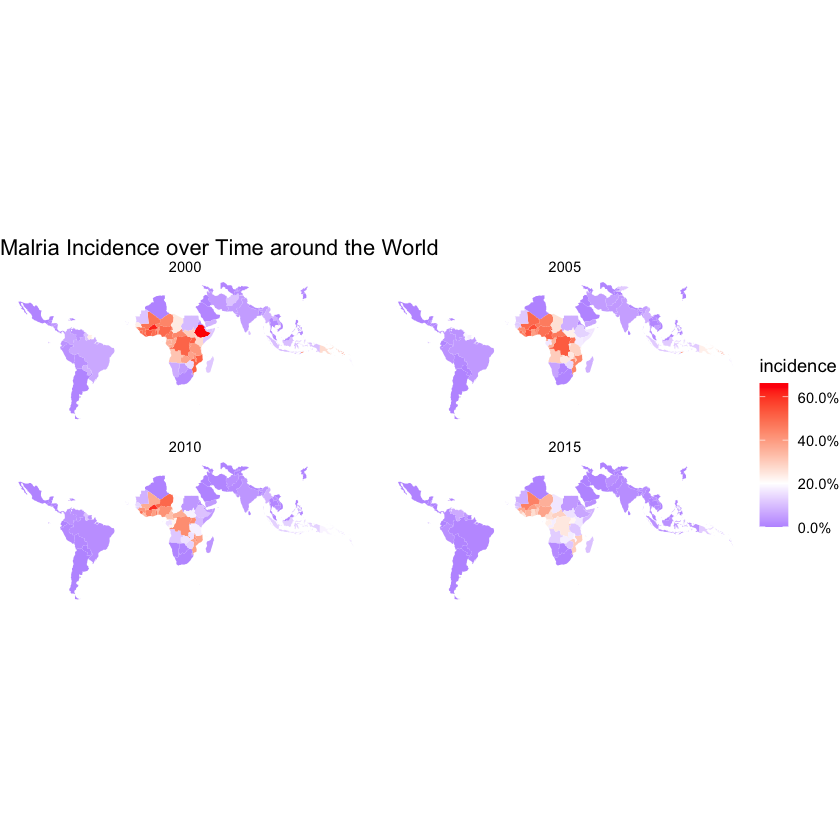

In [14]:
malaria_inc_processed %>% 
                        inner_join(maps::iso3166 %>% select(a3, mapname), by = c(code = 'a3')) %>%
                        left_join(world, by = c(mapname = 'region')) %>%
                        ggplot(aes(long, lat, group = group, fill = incidence)) +
                        geom_polygon() +
                        scale_fill_gradient2(low = 'blue', high = 'red', midpoint = 0.20, 
                                             label = scales::percent_format()) +
                        coord_map() +
                        theme_void() +
                        facet_wrap(~year) +
                        labs(title = 'Malria Incidence over Time around the World')

## Deaths

In [15]:
malaria_deaths <- read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2018/2018-11-13/malaria_deaths.csv")
      

names(malaria_deaths)

Parsed with column specification:
cols(
  Entity = col_character(),
  Code = col_character(),
  Year = col_double(),
  `Deaths - Malaria - Sex: Both - Age: Age-standardized (Rate) (per 100,000 people)` = col_double()
)


[1] "Entity"                                                                          
[2] "Code"                                                                            
[3] "Year"                                                                            
[4] "Deaths - Malaria - Sex: Both - Age: Age-standardized (Rate) (per 100,000 people)"

In [19]:
malaria_deaths_processed <- malaria_deaths %>%                     
                                set_names(c('country', 'code', 'year', 'deaths')) %>%
                                filter(country != 'Turkey') 


head(malaria_deaths_processed)

country,code,year,deaths
<chr>,<chr>,<dbl>,<dbl>
Afghanistan,AFG,1990,6.802930
Afghanistan,AFG,1991,6.973494
Afghanistan,AFG,1992,6.989882
Afghanistan,AFG,1993,7.088983
Afghanistan,AFG,1994,7.392472
Afghanistan,AFG,1995,7.405511


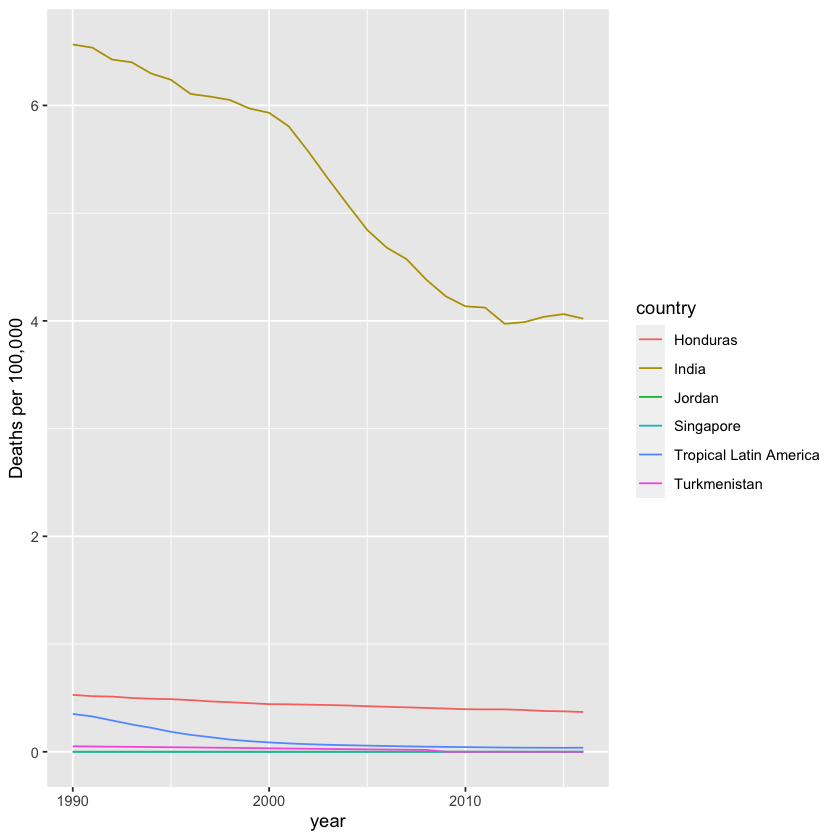

In [21]:
malaria_deaths_processed %>% filter(country %in% sample(unique(country), 6)) %>%
                ggplot(aes(year, deaths, color = country)) +
                geom_line() + 
                labs(y = 'Deaths per 100,000')

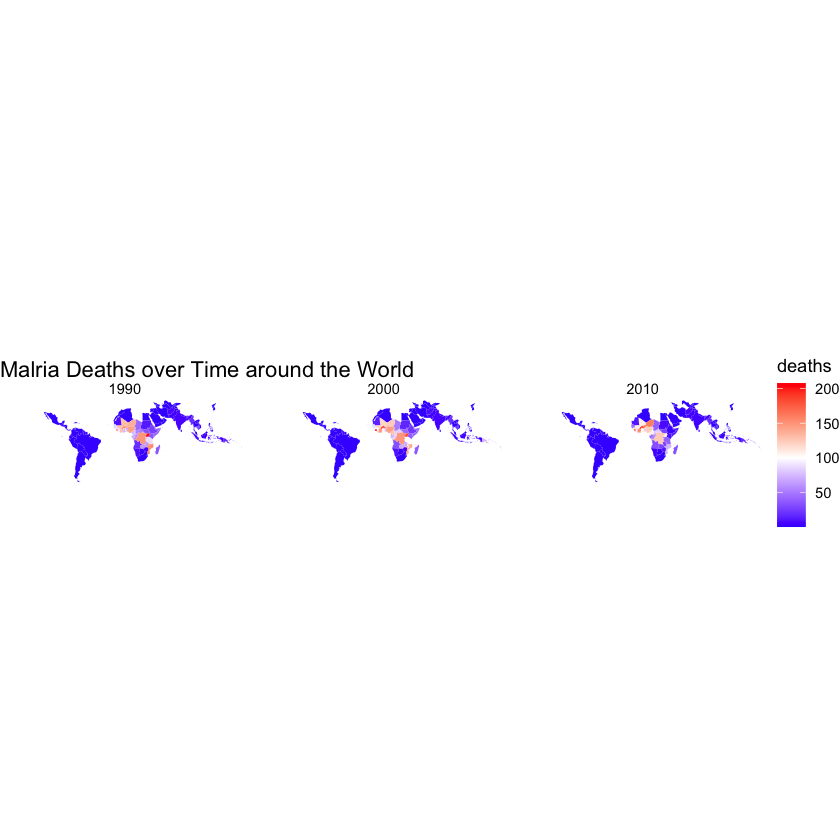

In [36]:
malaria_deaths_processed %>% 
                        inner_join(maps::iso3166 %>% select(a3, mapname), by = c(code = 'a3')) %>%
                        inner_join(world, by = c(mapname = 'region')) %>%
                        filter(year %% 10 == 0, deaths != 0) %>%
                        ggplot(aes(long, lat, group = group, fill = deaths)) +
                        geom_polygon() +
                        scale_fill_gradient2(low = 'blue', high = 'red', midpoint = 100) +
                        coord_map() +
                        theme_void() +
                        facet_wrap(~year) +
                        labs(title = 'Malria Deaths over Time around the World')